In [1]:
#For this project i will try to rank the wines in the dataset obtained [here] in  one of three categories bad, descent, good. the dataset consist of 12
#colums, where the 12'th column is the quality, that i will use as labels.

In [3]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt

import csv
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset


import time
import os
import copy

import torch.optim as optim
from torch.optim import lr_scheduler

  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path = '/content/gdrive/My Drive/wine_data/winequality-white.csv'

In [6]:
file_out = pd.read_csv(path, delimiter=';')
file_out.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


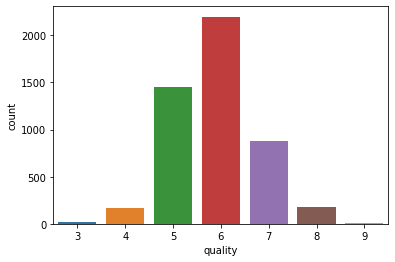

In [7]:
sns.countplot(x = 'quality', data=file_out)
# the distribution of feature labels are very uneven, which might be a problem

In [8]:
#convert labels into range 0,1,2 bad, descent, good

In [9]:
for i in range(len(file_out)):
  if file_out.iloc[i, 11] <= 5:
    file_out.iloc[i, 11] = 0
  elif file_out.iloc[i, 11] < 7:
    file_out.iloc[i, 11] = 1
  else:
    file_out.iloc[i, 11] = 2

In [10]:
data = file_out.iloc[:,: -1]
labels = file_out.iloc[:, 11]

In [11]:
# because the is a imbalance of classes, we use stratity to make sure that we have a balanced train and val set
data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [12]:
labels_train

3902    1
3800    0
757     1
4807    1
4468    1
       ..
3754    2
1766    0
1603    2
3766    0
4368    1
Name: quality, Length: 3918, dtype: int64

In [13]:
#normalizing the datasets between 0-1
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
#to avoid data-leakage, we scale the val set with the same parameters as the train set
data_val = scaler.transform(data_val)


#transforming to numpy arrays for further proccessing
data_train, labels_train = np.array(data_train), np.array(labels_train)
data_val, labels_val = np.array(data_val), np.array(labels_val)

In [16]:
#to make sure the distributaion is even we count the classes and plot each dataset

def get_distr(inp):
    count = {
        "bad": 0,
        "descent": 0,
        "good": 0,
    }
    
    for i in inp:
        if i == 0: 
            count['bad'] += 1
        elif i == 1: 
            count['descent'] += 1
        else:
          count['good'] += 1
            
    return count

Text(0.5, 1.0, 'distr of classes in val')

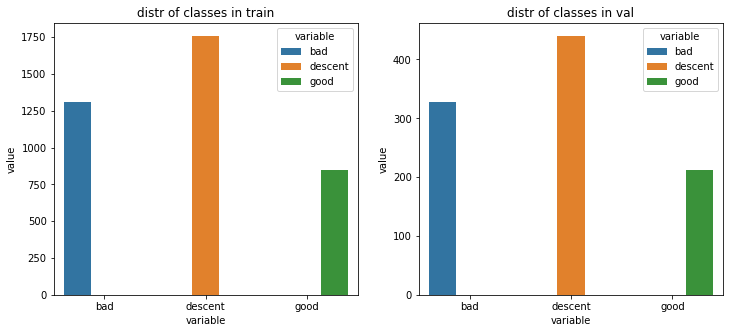

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# train labels
sns.barplot(data = pd.DataFrame.from_dict([get_distr(labels_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('distr of classes in train')
# val labels
sns.barplot(data = pd.DataFrame.from_dict([get_distr(labels_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('distr of classes in val')

In [18]:
#datasets for dataloader
class WineDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __getitem__(self, i):
        return self.data[i], self.labels[i]
        
    def __len__ (self):
        return len(self.data)


train_dset = WineDataset(torch.from_numpy(data_train).float(), torch.from_numpy(labels_train).long())
val_dset = WineDataset(torch.from_numpy(data_val).float(), torch.from_numpy(labels_val).long())

#making a dict, from the datasets for neater loop
datasets_dict= {'train' : train_dset, 'val' : val_dset }
dataset_sizes = {x: len(datasets_dict[x]) for x in ['train', 'val']}


In [19]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on device {device}.")
use_cuda = torch.cuda.is_available()


dataloaders = {x: torch.utils.data.DataLoader(datasets_dict[x], batch_size=20, shuffle=True, num_workers=2, pin_memory=use_cuda) for x in ['train', 'val']}


Training on device cuda.


In [32]:
class MultiClassNet(nn.Module):
    def __init__(self, features, classes):
        super(MultiClassNet, self).__init__()
        
        self.l1 = nn.Linear(features, 1024)
        self.l2 = nn.Linear(1024, 256)
        self.l3 = nn.Linear(256, 64)
        self.l4 = nn.Linear(64, 16)
        self.outL = nn.Linear(16, classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.bN1 = nn.BatchNorm1d(1024)
        self.bN2 = nn.BatchNorm1d(256)
        self.bN3 = nn.BatchNorm1d(64)
        self.bN4 = nn.BatchNorm1d(16)
        
    def forward(self, inp):
        inp = self.l1(inp)
        inp = self.bN1(inp)
        inp = self.relu(inp)

        inp = self.l2(inp)
        inp = self.bN2(inp)
        inp = self.relu(inp)

        inp = self.l3(inp)
        inp = self.bN3(inp)
        inp = self.relu(inp)
        inp = self.dropout(inp)

        inp = self.l4(inp)
        inp = self.bN4(inp)
        inp = self.relu(inp)
        
        inp = self.outL(inp)
        
        return inp

In [36]:
# I used nn.CrossEntropyLoss because this is a multiclass classification problem. 
model = MulticlassClassification(features = 11, classes =3)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

scheduler = lr_scheduler.StepLR( # each 7 steps decay lr by a factor of 0.7
    optimizer, step_size=50, gamma= 0.8
)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [37]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

               #forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # inp, dim
                    loss = loss_fn(outputs, labels)

                    # backwards pass
                    if phase == 'train':
                        loss.backward() # calculate gradiens
                        optimizer.step() # update params

                #stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print('\n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load weights of best model
    model.load_state_dict(best_model_wts)
    return model

In [39]:
model_hybrid = train_model(
    model = model, loss_fn = loss_fn, optimizer = optimizer, scheduler = scheduler, num_epochs=400
)

Epoch 0/399
----------
train Loss: 0.6102 Acc: 0.7284
val Loss: 0.7133 Acc: 0.6776


Epoch 1/399
----------
train Loss: 0.6000 Acc: 0.7356
val Loss: 0.7278 Acc: 0.6745


Epoch 2/399
----------
train Loss: 0.5920 Acc: 0.7346
val Loss: 0.7238 Acc: 0.6776


Epoch 3/399
----------
train Loss: 0.5777 Acc: 0.7514
val Loss: 0.7344 Acc: 0.6755


Epoch 4/399
----------
train Loss: 0.5907 Acc: 0.7284
val Loss: 0.7248 Acc: 0.6847


Epoch 5/399
----------
train Loss: 0.5907 Acc: 0.7397
val Loss: 0.7141 Acc: 0.6949


Epoch 6/399
----------
train Loss: 0.5967 Acc: 0.7266
val Loss: 0.7456 Acc: 0.6653


Epoch 7/399
----------
train Loss: 0.5839 Acc: 0.7412
val Loss: 0.7301 Acc: 0.6663


Epoch 8/399
----------
train Loss: 0.5740 Acc: 0.7437
val Loss: 0.7182 Acc: 0.6776


Epoch 9/399
----------
train Loss: 0.5830 Acc: 0.7407
val Loss: 0.7143 Acc: 0.6735


Epoch 10/399
----------
train Loss: 0.5943 Acc: 0.7340
val Loss: 0.7154 Acc: 0.6857


Epoch 11/399
----------
train Loss: 0.5779 Acc: 0.7407
val Loss: